$s$

In [1]:
import ipywidgets as widgets
out = widgets.Output()
with out:
    
    %bookmark 'model_dir'
    current_dir = %pwd
    while 'models' in current_dir:
        %cd ..
        current_dir = %pwd
    %bookmark 'base_dir'
    %cd source_code
    out.clear_output()
%run base
%run gui_v6
with out:
    %cd ..
    %cd models/fourbar
    out.clear_output()


In [2]:
m=model()
m.show()

## VEHICLE DYNAMICS MODELING AND SIMULATION TOOL

In [3]:
m.topology.edges

OutMultiEdgeView([(rbs_ground, rbs_link, 'jcs_rev')])

In [4]:
def equations_assembler(topology):
    
    edgelist = topology.edges(data='obj')
    nodelist = topology.nodes
    
    n_nodes = len(nodelist)
    n_edges = len(edgelist)
            
    jacobian = np.zeros((n_edges+n_nodes,n_nodes),dtype=np.object)
    jacobian.fill(None)
    
    equations = np.zeros((n_edges+n_nodes),dtype=np.object)
    
    vel_rhs = np.zeros((n_edges+n_nodes),dtype=np.object)
    acc_rhs = np.zeros((n_edges+n_nodes),dtype=np.object)
    
    reaction_vector = np.zeros((n_edges),dtype=np.object)
    reaction_indecies = np.zeros((n_edges),dtype=np.object)
    
    lamda_vector = np.zeros((n_edges+n_nodes),dtype=np.object)
    
    node_index = dict( (node,i) for i,node in enumerate(nodelist) )
    
    n7 = np.arange(7)
    for ei,e in enumerate(edgelist):
        (u,v) = e[:2]
        eo    = e[2]
        
        ui = node_index[u]
        vi = node_index[v]
        
        ui7 = (ui*7)+n7
        vi7 = (vi*7)+n7
        
        if jacobian[ui+n_edges,ui]==None: jacobian[ui+n_edges,ui] = (u.jac,ui7)
        if jacobian[vi+n_edges,vi]==None: jacobian[vi+n_edges,vi] = (v.jac,vi7)
                
        jacobian[ei,ui] = (eo.jacobian_i,ui7,vi7)
        jacobian[ei,vi] = (eo.jacobian_j,ui7,vi7)
        
        equations[ei] = (eo.equations,ui7,vi7)
        if equations[ui+n_edges]==0: equations[ui+n_edges]=(u.equations,ui7)
        if equations[vi+n_edges]==0: equations[vi+n_edges]=(v.equations,vi7)
        
        
        vel_rhs[ei] = ((eo.vel_rhs) if eo.nc==1 else np.zeros((eo.nc,1)))
        vel_rhs[ui+n_edges] = (np.array([[0]]) if u.nc==1 else np.zeros((7,1)))
        vel_rhs[vi+n_edges] = (np.array([[0]]) if v.nc==1 else np.zeros((7,1)))
        
        acc_rhs[ei] = (eo.acc_rhs,ui7,vi7)
        if acc_rhs[ui+n_edges]==0: acc_rhs[ui+n_edges]=(u.acc_rhs,ui7)
        if acc_rhs[vi+n_edges]==0: acc_rhs[vi+n_edges]=(v.acc_rhs,vi7)
            
        reaction_vector[ei] = (eo.reactions,ui7,vi7,eo.index)
        reaction_indecies[ei] = eo.reaction_index
        
        lamda_vector[ei] = eo.index
        if lamda_vector[ui+n_edges]==0: lamda_vector[ui+n_edges]=u.index
        if lamda_vector[vi+n_edges]==0: lamda_vector[vi+n_edges]=v.index
        
    #####################################################
    # Defining vectorized functions
    #####################################################
    
    def j_mapper(i,q):
        if len(i)==3:
            fun,bi,bj = i
            return fun(q[bi],q[bj])
        else:
            fun,bi = i
            return fun(q[bi])
    j_vectorized = np.vectorize(j_mapper,otypes=[np.object],excluded='q')
    
    
    def v_mapper(i):
        if isinstance(i,(int,np.ndarray)):
            return i
        else:
            return i()
    v_vectorized = np.vectorize(v_mapper,otypes=[np.object])
    
    def a_mapper(i,q,qd):
        if len(i)==3:
            fun,bi,bj = i
            return fun(q[bi],q[bj],qd[bi],qd[bj])
        else:
            fun,bi = i
            return fun(qd[bi])
    a_vectorized = np.vectorize(a_mapper,otypes=[np.object],excluded=('q','qd'))
    
    def r_mapper(i,q,lamda):
        fun,bi,bj,index = i
        return fun(q[bi],q[bj],lamda[index].values)
    r_vectorized = np.vectorize(r_mapper,otypes=[np.object],excluded=('q','lamda'))
    
    ####################################################################################
    ####################################################################################
    
    mass_matrix = np.zeros((n_nodes,n_nodes),dtype=np.object)
    mass_matrix.fill(None)
    
    gravitational_vector = np.zeros((n_nodes),dtype=np.object)
    centrifugal_vector   = np.zeros((n_nodes),dtype=np.object)
    inertiaforce_vector  = np.zeros((n_nodes),dtype=np.object)
    
    for n in nodelist:
        ni = node_index[n]
        ni7 = (ni*7)+n7
        
        mass_matrix[ni,ni]=(n.mass_matrix,ni7)
        
        gravitational_vector[ni]=n.gravity
        
        centrifugal_vector[ni]=(n.centrifugal,ni7)
        
        inertiaforce_vector[ni]=(n.inertia_force,ni7)
        
        
    def mass_mapper(i,q):
        fun,bi = i
        return fun(q[bi])
    mass_vectorized = np.vectorize(mass_mapper,otypes=[np.object],excluded='q')
    
    def centrifugal_mapper(i,q,qd):
        fun,bi = i
        return fun(q[bi],qd[bi])
    centrifugal_vectorized = np.vectorize(centrifugal_mapper,otypes=[np.object],excluded=('q','qd'))
    
    def gravity_mapper(i):
        return i()
    gravity_vectorized = np.vectorize(gravity_mapper,otypes=[np.object])
    
    
    system = pd.Series([jacobian,
                        jacobian.nonzero(),
                        equations, 
                        vel_rhs, 
                        acc_rhs,
                        reaction_vector,
                        reaction_indecies,
                        lamda_vector,
                        mass_matrix,
                        gravitational_vector,
                        centrifugal_vector,
                        inertiaforce_vector,
                        j_vectorized,
                        v_vectorized,
                        a_vectorized,
                        r_vectorized,
                        mass_vectorized,
                        centrifugal_vectorized,
                        gravity_vectorized],
                       index=['Jacobian','Jnzi','Ceq','Veq','Aeq','Rvec','Rind','Lind',
                              'MassMatrix','Gravity','Centrifugal','Inertia',
                              'Jf','Vf','Af','Rf','Mf','Cf','Gf'])
    
    return system


In [5]:
def jacobian_evaluator(jac_blocks,nzi,mapper,q,Id=None):
    A = jac_blocks.copy()
    A[nzi]=mapper(A[nzi],q=q)
    
    if Id is None:
        return sc.sparse.bmat(A,format='csc')
    else:
        J = sc.sparse.bmat(A,format='csc')
        return sc.sparse.bmat([[J],[Id]])
    

In [6]:
def nr_kds(jac_blocks,equations_blocks,nzi,j_vectorized,guess,Id=None):
    
    A = jacobian_evaluator(jac_blocks,nzi,j_vectorized,guess,Id)
    
    b = equations_blocks.copy()
    bn = np.concatenate(j_vectorized(b[b.nonzero()],q=guess))
    
    if Id is not None:
        nqind=Id.shape[0]
        Ieq=np.zeros((nqind,1))
        bn = np.concatenate([bn,Ieq])
        
    delta_q = sc.sparse.linalg.spsolve(A,-bn)
    
    itr=0
    while np.linalg.norm(delta_q)>1e-5:
        
        guess=guess+delta_q
        
        if itr!=0 and itr%5==0:
            print('Recalculating Jacobian')
            A = jacobian_evaluator(jac_blocks,nzi,j_vectorized,guess,Id)
        bn = np.concatenate(j_vectorized(b[b.nonzero()],q=guess))
        if Id is not None:
            nqind=Id.shape[0]
            Ieq=np.zeros((nqind,1))
            bn = np.concatenate([bn,Ieq])
        delta_q = sc.sparse.linalg.spsolve(A,-bn)
        
        itr+=1
        
        if itr>200:
            print("Iterations exceded \n")
            break    
    
    return guess,jacobian_evaluator(jac_blocks,nzi,j_vectorized,guess,Id)


In [122]:
def coordinates_mapper(q):
    n=len(q)
    int2str=pd.Series(q.index,index=np.arange(0,n,1))
    str2int=pd.Series(np.arange(0,n,1),index=q.index)
    return int2str, str2int

def extract_ind(sparse_jac,q):
    mat=sparse_jac.A
    rows,cols=mat.shape
    permR=sc.linalg.lu(mat.T)[0]
    ind_cols=permR[:,rows:]
    maped=coordinates_mapper(q)[0]
    ind_coord=[maped[np.argmax(ind_cols[:,i])] for i in range(cols-rows) ]
    
    return ind_coord, ind_cols, permR

def assign_initial_conditions(q0,qd0,qind):
    q_initial  = list(q0[qind])
    qd_initial = list(qd0[qind])
    return q_initial+qd_initial

def state_space_creator():
    
    def ssm(t,y,Mii,Mid,Qti,Cqi,lamda,qdd_d):
        
        v=list(y[len(y)//2:])
        vdot=np.linalg.inv(Mii)@(Qei-Cqi.T@lamda-Mid@qdd_d)
        vdot=list(vdot)
        dydt=v+vdot
        return dydt
    
    return ssm


def dds(q0,qd0,system_equations,time_array):
    '''
    Dynamically Driven Systems Solver
    '''
    #Qa_f = system_equations.Qa
    Cf = system_equations.Cf
    Gf = system_equations.Gf
    Mf  = system_equations.Mf
    Jf = eq_f = system_equations.Jf
    Af = system_equations.Af
    Vf = system_equations.Vf
    Rf = system_equations.Rf
    
    Cv = system_equations.Centrifugal
    Gv = system_equations.Gravity
    Mm  = system_equations.MassMatrix
    Jm = eq_f = system_equations.Jacobian
    Av = system_equations.Aeq
    Vv = system_equations.Veq
    Ev = system_equations.Ceq
    Rv = system_equations.Rvec
    Jnzi = system_equations.Jnzi
    

    # assigning initial conditions to the system NE equations
    M  = sc.sparse.block_diag(Mf(Mm.diagonal(),q=q0.values),format='csc')
    J  = jacobian_evaluator(Jm,Jnzi,Jf,q0.values)
    Qv = np.concatenate(Cf(Cv,q=q0.values,qd=qd0.values))
    Qg = np.concatenate(Gf(Gv))
    Qt = (Qv+Qg)
    Qd = np.concatenate(Af(Av,q=q0.values,qd=qd0.values))
    
    # Initiating coordinate partitioning
    qind=extract_ind(J,q0)
    qstr=qind[0]
    Ids=qind[1]
    perm_matrix = sc.sparse.csc_matrix(qind[2]).T
    qind_index=list(coordinates_mapper(q0)[1][qstr])
    dof = len(qstr)
    print('DOF : %s \n' %dof)
    print('Independent Coordinates are: %s with indices: %s \n'%(qstr,qind_index))
    
    
    # creating dataframes to hold the simulation results at each timestep
    # with initial conditions at t0
    position_df=pd.DataFrame(columns=q0.index)
    velocity_df=pd.DataFrame(columns=q0.index)
    acceleration_df=pd.DataFrame(columns=q0.index)
    lamda_df=pd.DataFrame(columns=np.concatenate(system_equations.Lind))
    JR_df=pd.DataFrame(columns=np.concatenate(system_equations.Rind))
    
    position_df.loc[0]=q0
    velocity_df.loc[0]=qd0
    
    
    # assembling the coefficient matrix and the rhs vector and solving for
    # system accelerations and lagrange multipliers
    coeff_matrix=sc.sparse.bmat([[M,-J.T],[J,None]],format='csc')
    b_vector=np.concatenate([Qt,Qd])
    x=sc.sparse.linalg.spsolve(coeff_matrix,-b_vector)
    
    # updating the dataframes with the evaluated results
    qdd0n  = x[:len(q0)] # the first 7xnb elements in the x vector
    lamda0 = x[len(q0):] # the rest of elements in the x vector
    acceleration_df.loc[0]=qdd0n
    lamda_df.loc[0]=lamda0
    
    reaction=Rf(Rv,q=q0.values,lamda=lamda_df.loc[0])
    JR_df.loc[0]=np.concatenate(reaction)

    
    # Setting up the integrator function and the initial conditions
    
    def ssm(t,y,Mii,Mid,Qti,Cqi,lamda,qdd_d):
        
        v=list(y[len(y)//2:])
        vdot=sc.sparse.linalg.spsolve(Mii,(-Qti.flatten()+(Cqi.T@lamda)-(Mid@qdd_d)))
        vdot=list(vdot)
        dydt=v+vdot
        return dydt
    

    Mp = perm_matrix@M@perm_matrix.T
    Mii = Mp[-dof:,-dof:]
    Mid = Mp[-dof:,:-dof]
    
    Qtp = perm_matrix@Qt
    Qti = Qtp[-dof:]
    
    Cqp = J@perm_matrix.T
    Cqi = Cqp[:,-dof:]
    
    qdd_d = (perm_matrix@qdd0n)[:-dof]
    
    
    r=sc.integrate.ode(ssm).set_integrator('dop853')
    y0=assign_initial_conditions(q0,qd0,qstr)
    r.set_initial_value(y0).set_f_params(Mii,Mid,Qti,Cqi,lamda0,qdd_d)
    
    # Setting up the time array to be used in integration steps and starting
    # the integration
    for i,dt in enumerate(time_array):
#        print('time_step: '+str(i))
        #progress_bar(len(t),i)

        r.integrate(dt)
#        print(r.y)
#        if not r.successful():
#            print("BREAKING SOLVER")
#            return position_df,velocity_df,acceleration_df,JR_df
        
        # creating the guess vector for the vector q as the values of the 
        # previous step and the value of newly evaluated independent coordinate
        guess=position_df.loc[i]+velocity_df.loc[i]*dt + 0.5*acceleration_df.loc[i]*dt**2
        guess[qstr]=r.y[:len(r.y)//2]
        
        # Evaluating the dependent vector q using newton raphson
        dependent=nr_kds(Jm,Ev,Jnzi,Jf,guess,Ids.T)
        position_df.loc[i+1]=dependent[0]
        Cq_new=dependent[1]
        # Calculating the system velocities
        vrhs=np.concatenate(Vf(Vv))
        vind=np.array(r.y[len(r.y)//2:]).reshape((len(r.y)//2,1))
        vrhs=np.concatenate([-vrhs,vind])
        velocity_df.loc[i+1]=sc.sparse.linalg.spsolve(Cq_new,vrhs)
        
        
        q=position_df.loc[i+1]
        qd=velocity_df.loc[i+1]
        
        # Evaluating the new coeff matrix bloks of the system NE equations
        M  = sc.sparse.block_diag(Mf(Mm.diagonal(),q=q.values),format='csc')
        J  = jacobian_evaluator(Jm,Jnzi,Jf,q.values)
        Qv = np.concatenate(Cf(Cv,q=q.values,qd=qd.values))
        Qg = np.concatenate(Gf(Gv))
        Qt = (Qv+Qg)
        Qd = np.concatenate(Af(Av,q=q.values,qd=qd.values))

        coeff_matrix=sc.sparse.bmat([[M,-J.T],[J,None]],format='csc')
        b_vector=np.concatenate([Qt,Qd])
        # Evaluating the acceleration and lagrange mult. vector
        x=sc.sparse.linalg.spsolve(coeff_matrix,-b_vector)
        
        # updating the dataframes with the evaluated results
        qdd   = x[:len(q0)] # the first 7xnb elements in the x vector
        lamda = x[len(q0):] # the rest of elements in the x vector
        acceleration_df.loc[i+1]=qdd
        lamda_df.loc[i+1]=lamda
        reaction=Rf(Rv,q=q.values,lamda=lamda_df.loc[i+1])
        JR_df.loc[i+1]=np.concatenate(reaction)
        

        # Setting the ssm input parameters
        Mp = perm_matrix@M@perm_matrix.T
        Mii = Mp[-dof:,-dof:]
        Mid = Mp[-dof:,:-dof]

        Qtp = perm_matrix@Qt
        Qti = Qtp[-dof:]

        Cqp = J@perm_matrix.T
        Cqi = Cqp[:,-dof:]

        qdd_d = (perm_matrix@qdd0n)[:-dof]
        
        r.set_f_params(Mii,Mid,Qti,Cqi,lamda,qdd_d)
    
    
    return position_df,velocity_df,acceleration_df,JR_df


In [123]:
import scipy as sc
q0=pd.concat([i.q0 for i in m.topology.nodes])
assembled = equations_assembler(m.topology)
np.concatenate(assembled.Rind)

array(['jcs_rev_Fx', 'jcs_rev_Fy', 'jcs_rev_Fz', 'jcs_rev_Mx',
       'jcs_rev_My', 'jcs_rev_Mz'],
      dtype='<U10')

In [124]:
d= dds(q0,0*q0,assembled,np.arange(0.001,0.5,0.001))

DOF : 1 

Independent Coordinates are: ['rbs_link.z'] with indices: [9] 



C:\Users\khaled.ghobashy\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:102: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculati

In [126]:
d[0]

,rbs_ground.x,rbs_ground.y,rbs_ground.z,rbs_ground.e0,rbs_ground.e1,rbs_ground.e2,rbs_ground.e3,rbs_link.x,rbs_link.y,rbs_link.z,rbs_link.e0,rbs_link.e1,rbs_link.e2,rbs_link.e3
0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e+03,0.000000e+00,0.000000,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
1,6.252776e-19,2.063483e-19,-4.547474e-19,1.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e+03,9.266144e-20,0.003679,-2.705985e-01,6.532803e-01,-2.705976e-01,6.532827e-01
2,5.854872e-18,3.386372e-18,-5.911716e-18,1.000000e+00,1.095862e-21,0.0,9.922241e-23,1.000000e+03,3.097031e-18,0.014714,-2.706025e-01,6.532707e-01,-2.705936e-01,6.532923e-01
3,5.962730e-19,0.000000e+00,0.000000e+00,1.000000e+00,3.562999e-21,0.0,-3.693466e-22,1.000000e+03,-2.972069e-14,0.033107,-2.706025e-01,6.532707e-01,-2.705936e-01,6.532923e-01
4,-3.576306e-19,0.000000e+00,0.000000e+00,1.000000e+00,4.880932e-23,0.0,-3.323854e-22,1.000000e+03,-4.382668e-18,0.058858,-2.706060e-01,6.532623e-01,-2.705901e-01,6.533007e-01
5,-1.562335e-21,0.000000e+00,0.000000e+00,1.000000e+00,-4.338048e-25,0.0,-2.243162e-25,1.000000e+03,-6.897719e-14,0.091965,-2.706105e-01,6.532514e-01,-2.705856e-01,6.533115e-01
6,-2.241913e-21,0.000000e+00,0.000000e+00,1.000000e+00,6.992307e-25,0.0,-6.676230e-25,1.000000e+03,9.469628e-15,0.132429,-2.706160e-01,6.532382e-01,-2.705801e-01,6.533247e-01
7,1.594428e-21,0.000000e+00,0.000000e+00,1.000000e+00,-1.582072e-24,0.0,-1.304460e-24,1.000000e+03,-6.743991e-15,0.180251,-2.706224e-01,6.532226e-01,-2.705737e-01,6.533404e-01
8,-1.728457e-20,0.000000e+00,0.000000e+00,1.000000e+00,6.916840e-25,0.0,-3.885825e-24,1.000000e+03,-3.916464e-14,0.235430,-2.706299e-01,6.532046e-01,-2.705662e-01,6.533584e-01
9,-2.147371e-21,0.000000e+00,0.000000e+00,1.000000e+00,-8.415492e-24,0.0,-7.303403e-25,1.000000e+03,-6.730446e-15,0.297966,-2.706384e-01,6.531841e-01,-2.705577e-01,6.533788e-01


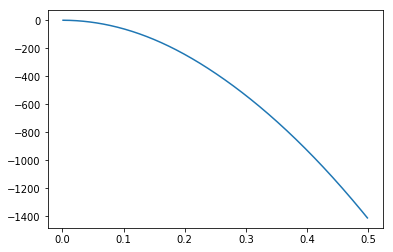

In [107]:
plt.plot(np.arange(0.001,0.5,0.001)[:],d[0]['rbs_link.z'][1:])
plt.show()